In [14]:
import numpy as np
import matplotlib.pyplot as plt
from generate_valid_env import generate_centered_stable_weights
from environment import Environment
from lds import *

In [15]:
def compute_bias_term(k, beta_a, Gamma, K, s, z_s_tilde):
    c_a = compute_c_a(k, beta_a)
    C = compute_C(k)
    A = Gamma - Gamma @ K @ C
    A_s = np.linalg.matrix_power(A, s)

    return c_a @ A_s @ z_s_tilde

def create_env_params(k, sigma_z, sigma_r):
    gammas = generate_centered_stable_weights(k, 2, 123)
    env_params = dict(gamma_0=0,
            mu_a=[0, 0],
            beta_a=[-10.0, 10.0],
            sigma_z=sigma_z,
            sigma_r=sigma_r,
            K=k,
            gammas=gammas,
            init_zs=np.ones(k)
            )
    np.random.seed(2024)
    env_params['init_zs'] = 10 * np.random.randn(env_params['K'])

    return env_params

## Test Helper Functions
---

In [16]:
k = 2
gammas = generate_centered_stable_weights(k, 2, 123)
Gamma = create_Gamma_from_gammas(gammas)
sigma_z = 1e-3
C = compute_C(k)
# Define system matrices
A = Gamma.T
B = C.T
W = np.diag([sigma_z**2, 0])
V = np.array([[0.1**2]])

In [17]:
P = compute_P(Gamma, C, W, V)
print(P)

[[1.49991565e-06 4.99921892e-07]
 [4.99921892e-07 1.49969070e-06]]


In [18]:
K = compute_K(P, C, V)
print(K)

[[1.4996907e-04]
 [4.9984692e-05]]


## Testing Kalman Filter
---

### Test Steady-State Kalman Filter Is Reasonable

In [19]:
NUM_TIME_STEPS = 100
## ENVIRONMENT ##
k = 2
sigma_z = 1e-3
sigma_r = 10
env_params = create_env_params(k, sigma_z, sigma_r)
print(f"init_zs: {env_params['init_zs']}")

# LDS
Gamma = create_Gamma_from_gammas(gammas)
C = compute_C(k)
W = np.diag(np.zeros(k))
W[0][0] = sigma_z**2
V = np.array([[sigma_r**2 / np.min(np.power(env_params["beta_a"], 2))]])
mu_z = np.zeros(k)
mu_z[0] = env_params['gamma_0']
# print(f"GAMMA: {Gamma}")
# print(f"C: {C}")
# print(f"W: {W}")
# print(f"V: {V}")
# print(f"mu_z: {mu_z}")

init_zs: [16.68047321  7.37347727]


In [20]:
ENV = Environment(env_params, T=NUM_TIME_STEPS)
np.random.seed(1)
T = ENV.get_T()
K = ENV.K
# steady-state params
z_tildes = np.zeros((T, K))
z_tildes[K - 1, :] = np.flip(env_params['init_zs'])
true_position = np.zeros(T)
predictions = np.zeros(T)
observations = np.zeros(T)
# initializing the first K values
for _ in range(K):
    t = ENV.get_t()
    z_t = ENV.get_all_zs()[t]
    true_position[t] = z_t
    if t >= K:
        # steady-state
        last_z_tilde = z_tildes[t - 1]
        P = compute_P(Gamma, C, W, V)
        Kalman_Gain = compute_K(P, C, V)
        last_y = observations[t - 1]
        z_tilde = compute_z_tilde(Gamma, Kalman_Gain, C, last_z_tilde, mu_z, [last_y])
        z_tildes[t] = z_tilde
        predictions[t] = z_tilde[0]
        print(f"t:{t} z_tilde: {z_tildes[t][0]}, true z: {z_t}, last_y: {last_y}")
    else:
        predictions[t] = z_tildes[t][0]
        print(f"t:{t} z_tilde: {z_tildes[t][0]}, true z: {z_t}")
    reward = ENV.get_reward(0)
    y_t = (reward - env_params['mu_a'][0]) / env_params['beta_a'][0]
    observations[t] = y_t
    ENV.increment_t()
while ENV.get_t() < T:
    ### environment ###
    t = ENV.get_t()
    ENV.state_evolution()
    z_t = ENV.get_all_zs()[t]
    ### steady-state ###
    last_z_tilde = z_tildes[t - 1]
    P = compute_P(Gamma, C, W, V)
    Kalman_Gain = compute_K(P, C, V)
    last_y = observations[t - 1]
    z_tilde = compute_z_tilde(Gamma, Kalman_Gain, C, last_z_tilde, mu_z, [last_y])
    # print(f"t:{t} z_tilde: {z_tilde[0]}, true z: {z_t}, last_y: {last_y}")
    z_tildes[t] = z_tilde
    action = t % 2
    reward = ENV.get_reward(action)
    # print(f"t: {t}, reward: {reward}, reward noise: {ENV.reward_noises[t]}, z: {ENV.zs[t]}")
    y_t = (reward - env_params['mu_a'][action]) / env_params['beta_a'][action]
    true_position[t] = z_t
    predictions[t] = z_tilde[0]
    observations[t] = y_t
    ### increment t ###  
    ENV.increment_t()

t:0 z_tilde: 0.0, true z: 16.68047321311954
t:1 z_tilde: 7.373477267548951, true z: 7.373477267548951


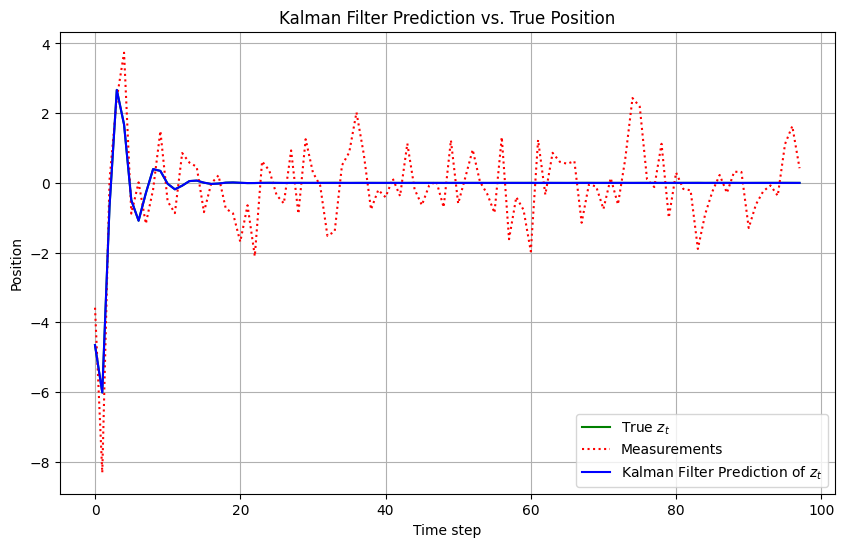

In [21]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(true_position[k:], label='True $z_t$', color='g')
plt.plot(observations[k:], label='Measurements', color='r', linestyle='dotted')
plt.plot(predictions[k:], label='Kalman Filter Prediction of $z_t$', color='b')
plt.xlabel('Time step')
plt.ylabel('Position')
plt.title('Kalman Filter Prediction vs. True Position')
plt.legend()
plt.grid()
plt.show()

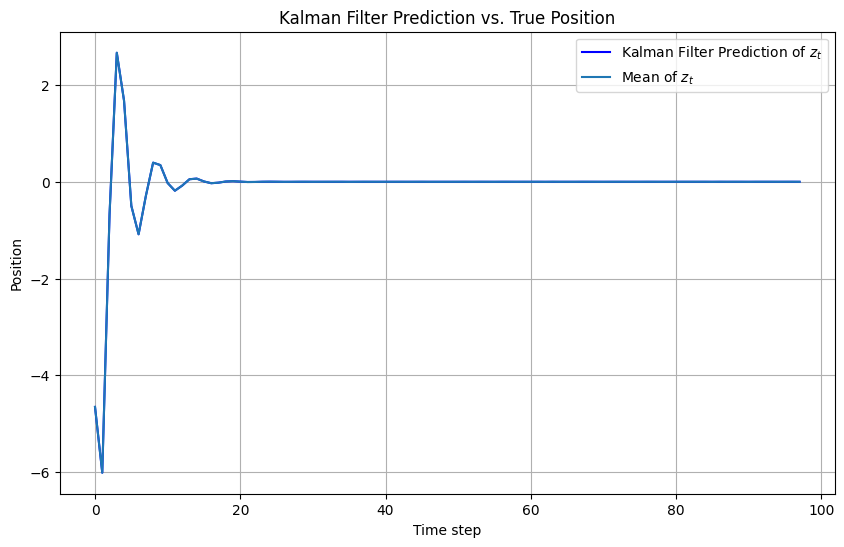

In [22]:
# Plotting the results
plt.figure(figsize=(10, 6))
# plt.plot(true_position, label='True $z_t$', color='g')
# plt.plot(observations, label='Measurements', color='r', linestyle='dotted')
plt.plot(predictions[k:], label='Kalman Filter Prediction of $z_t$', color='b')
means = true_position - ENV.z_noises
plt.plot(means[k:], label='Mean of $z_t$')
plt.xlabel('Time step')
plt.ylabel('Position')
plt.title('Kalman Filter Prediction vs. True Position')
plt.legend()
plt.grid()
plt.show()

## Testing Schur-ness
---

In [4]:
for k in range(2, 10):
    gammas = generate_centered_stable_weights(k, 2, 123)
    Gamma = create_Gamma_from_gammas(gammas)
    eigenvalues, eigenvectors = np.linalg.eig(Gamma)
    print(f"k = {k}, max eigenvalue for Gamma: {np.max(eigenvalues)}")
    assert np.max(eigenvalues) < 1

k = 2, max eigenvalue for Gamma: (0.25+0.6614378277661476j)
k = 3, max eigenvalue for Gamma: (0.4785013698899233+0.47753447916701586j)
k = 4, max eigenvalue for Gamma: (0.5509975592891113+0j)
k = 5, max eigenvalue for Gamma: (0.6632336816751925+0.3814973963922387j)
k = 6, max eigenvalue for Gamma: (0.6585382430052464+0.5494767415512358j)
k = 7, max eigenvalue for Gamma: (0.788994826080173+0.33010195522838937j)
k = 8, max eigenvalue for Gamma: (0.7302694715608192+0j)
k = 9, max eigenvalue for Gamma: (0.7758908890184465+0.25659644195109094j)


In [5]:
k = 2
beta_a = 1.0
gammas = generate_centered_stable_weights(k, 2, 123)
Gamma = create_Gamma_from_gammas(gammas)
C = compute_C(k)
W = np.diag(np.zeros(k))
W[0][0] = sigma_z**2
V = np.array([[0.1**2]])
P = compute_P(Gamma, C, W, V)
Kalman_Gain = compute_K(P, C, V)

In [6]:
eigenvalues, eigenvectors = np.linalg.eig(Gamma)
print(f"eigenvalues of Gamma: {eigenvalues}")
print(f"max eigenvalue for Gamma: {np.max(eigenvalues)}")
assert np.abs(np.max(eigenvalues)) < 1

eigenvalues of Gamma: [0.25+0.66143783j 0.25-0.66143783j]
max eigenvalue for Gamma: (0.25+0.6614378277661476j)


In [7]:
def compute_bias_term(k, beta_a, Gamma, K, s, z_s_tilde):
    c_a = compute_c_a(k, beta_a)
    C = compute_C(k)
    A = Gamma - Gamma @ K @ C
    A_s = np.linalg.matrix_power(A, s)

    return c_a @ A_s @ z_s_tilde

In [12]:
for s in range(1, 30):
    bias = compute_bias_term(k, beta_a, Gamma, Kalman_Gain, s, np.ones(k))
    print(f"s: {s}, bias: {bias}")

s: 1, bias: -4.9992189238678986e-05
s: 2, bias: -0.49995000906018383
s: 3, bias: -0.24992501858865082
s: 4, bias: 0.12498750101553037
s: 5, bias: 0.18743127089192949
s: 6, bias: 0.031221886968307425
s: 7, bias: -0.07809219836555986
s: 8, bias: -0.05465079750829199
s: 9, bias: 0.011717576834446533
s: 10, bias: 0.03317950341940036
s: 11, bias: 0.010730183213515921
s: 12, bias: -0.01122270857864938
s: 13, bias: -0.01097508025051056
s: 14, bias: 0.00012352130277156186
s: 15, bias: 0.005548471640249169
s: 16, bias: 0.0027122070506820574
s: 17, bias: -0.001417851834384582
s: 18, bias: -0.0020647551874309962
s: 19, bias: -0.00032345477185195294
s: 20, bias: 0.0008705115532936208
s: 21, bias: 0.0005969153896887492
s: 22, bias: -0.00013676264800533214
s: 23, bias: -0.00036678742235980136
s: 24, bias: -0.00011500430575460131
s: 25, bias: 0.00012586980423522762
s: 26, bias: 0.00012042213894342681
s: 27, bias: -2.7204145234906274e-06
s: 28, bias: -6.15621109358626e-05
s: 29, bias: -2.9417974570504